# Enantiomer Analysis

In this notebook, we will try to analyze whether the descriptors are capable of correctly clustering enantiomers.

In [63]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from descriptor_utils import DescriptorWrapper
from experiment_utils import compute_knn, plot_evaluation, compute_descriptors_from_file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
descriptor_list = [
    'evrap', 'sirm', 'scomp', 'samp', 'sector_model', 'shell_model', 'combined_model',
    'pfh', 'sirm_3d', 'scomp_3d', 'samp_3d'
]
with open(f"point_clouds/proteins.pkl", "rb") as f:
    data = pickle.load(f)
point_clouds = data['objects']
labels = data['labels']

In [4]:
np_labels = np.array(labels)
np.unique(np_labels, return_counts=True)

(array([0, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 9, 44, 27, 11, 43, 19, 67, 23,  1]))

We will pick clusters 3 and 7 to mirror with for particular reason, expect for their size.

In [5]:
for i in range(len(labels)):
    label = labels[i]
    if label == 3 or label == 7:
        mirrored_pc = point_clouds[i].copy()
        mirrored_pc[:, 2] = -mirrored_pc[:, 2]
        point_clouds.append(mirrored_pc)
        labels.append(-label)

In [33]:
descriptor_wrapper = DescriptorWrapper()
descriptor_embeddings = dict()

for descriptor in descriptor_list:
    desc_output = descriptor_wrapper.compute_model_on_dataset(point_clouds, descriptor)
    # need to convert for saving and loading
    desc_output = desc_output.tolist()
    descriptor_embeddings[descriptor] = desc_output

df = pd.DataFrame({k: list(v) for k, v in descriptor_embeddings.items()})
df["labels"] = labels
df.to_csv("test_output/proteins_mirrored.csv")

Previous tests have shown that clustering works best on symmetric, unweighted knn graphs, so we will use them

In [36]:
knn_types = ['symmetric', 'mutual']
descriptors = [
    ['evrap', 'samp', 'sirm', 'scomp'], ['pfh'], ['sector_model'], ['combined_model'],
    ['shell_model'], ['evrap'], ['samp'], ['sirm'], ['scomp'], ['samp_3d'], ['sirm_3d'], ['scomp_3d']
]

pickle_file = f"test_output/protein_mirrored_15_connectivity_nmi_ari.pkl"
if os.path.isfile(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
else:
    data = {
        metric: {'_'.join(descriptor): [] for descriptor in descriptors}
        for metric in ['nmi', 'ari']
    }
    data['cluster_size'] = []

    cluster_size = range(2, 21)
    for c in cluster_size:
        data['cluster_size'].append(c)
        for descriptor in descriptors:
            knn_graph = compute_knn(df, descriptor_list=descriptor, n_neighbors=15, variant='symmetric',
                                    mode='connectivity')

            spectral = SpectralClustering(
                n_clusters=c,
                affinity='precomputed',
                random_state=42,
                n_jobs=-1
            )
            predicted_labels = spectral.fit_predict(knn_graph)
            nmi = normalized_mutual_info_score(df["labels"], predicted_labels)
            ari = adjusted_rand_score(df["labels"], predicted_labels)

            data['nmi']['_'.join(descriptor)].append(nmi)
            data['ari']['_'.join(descriptor)].append(ari)
    with open(pickle_file, 'wb') as f:
        pickle.dump(data, f)

/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarnin

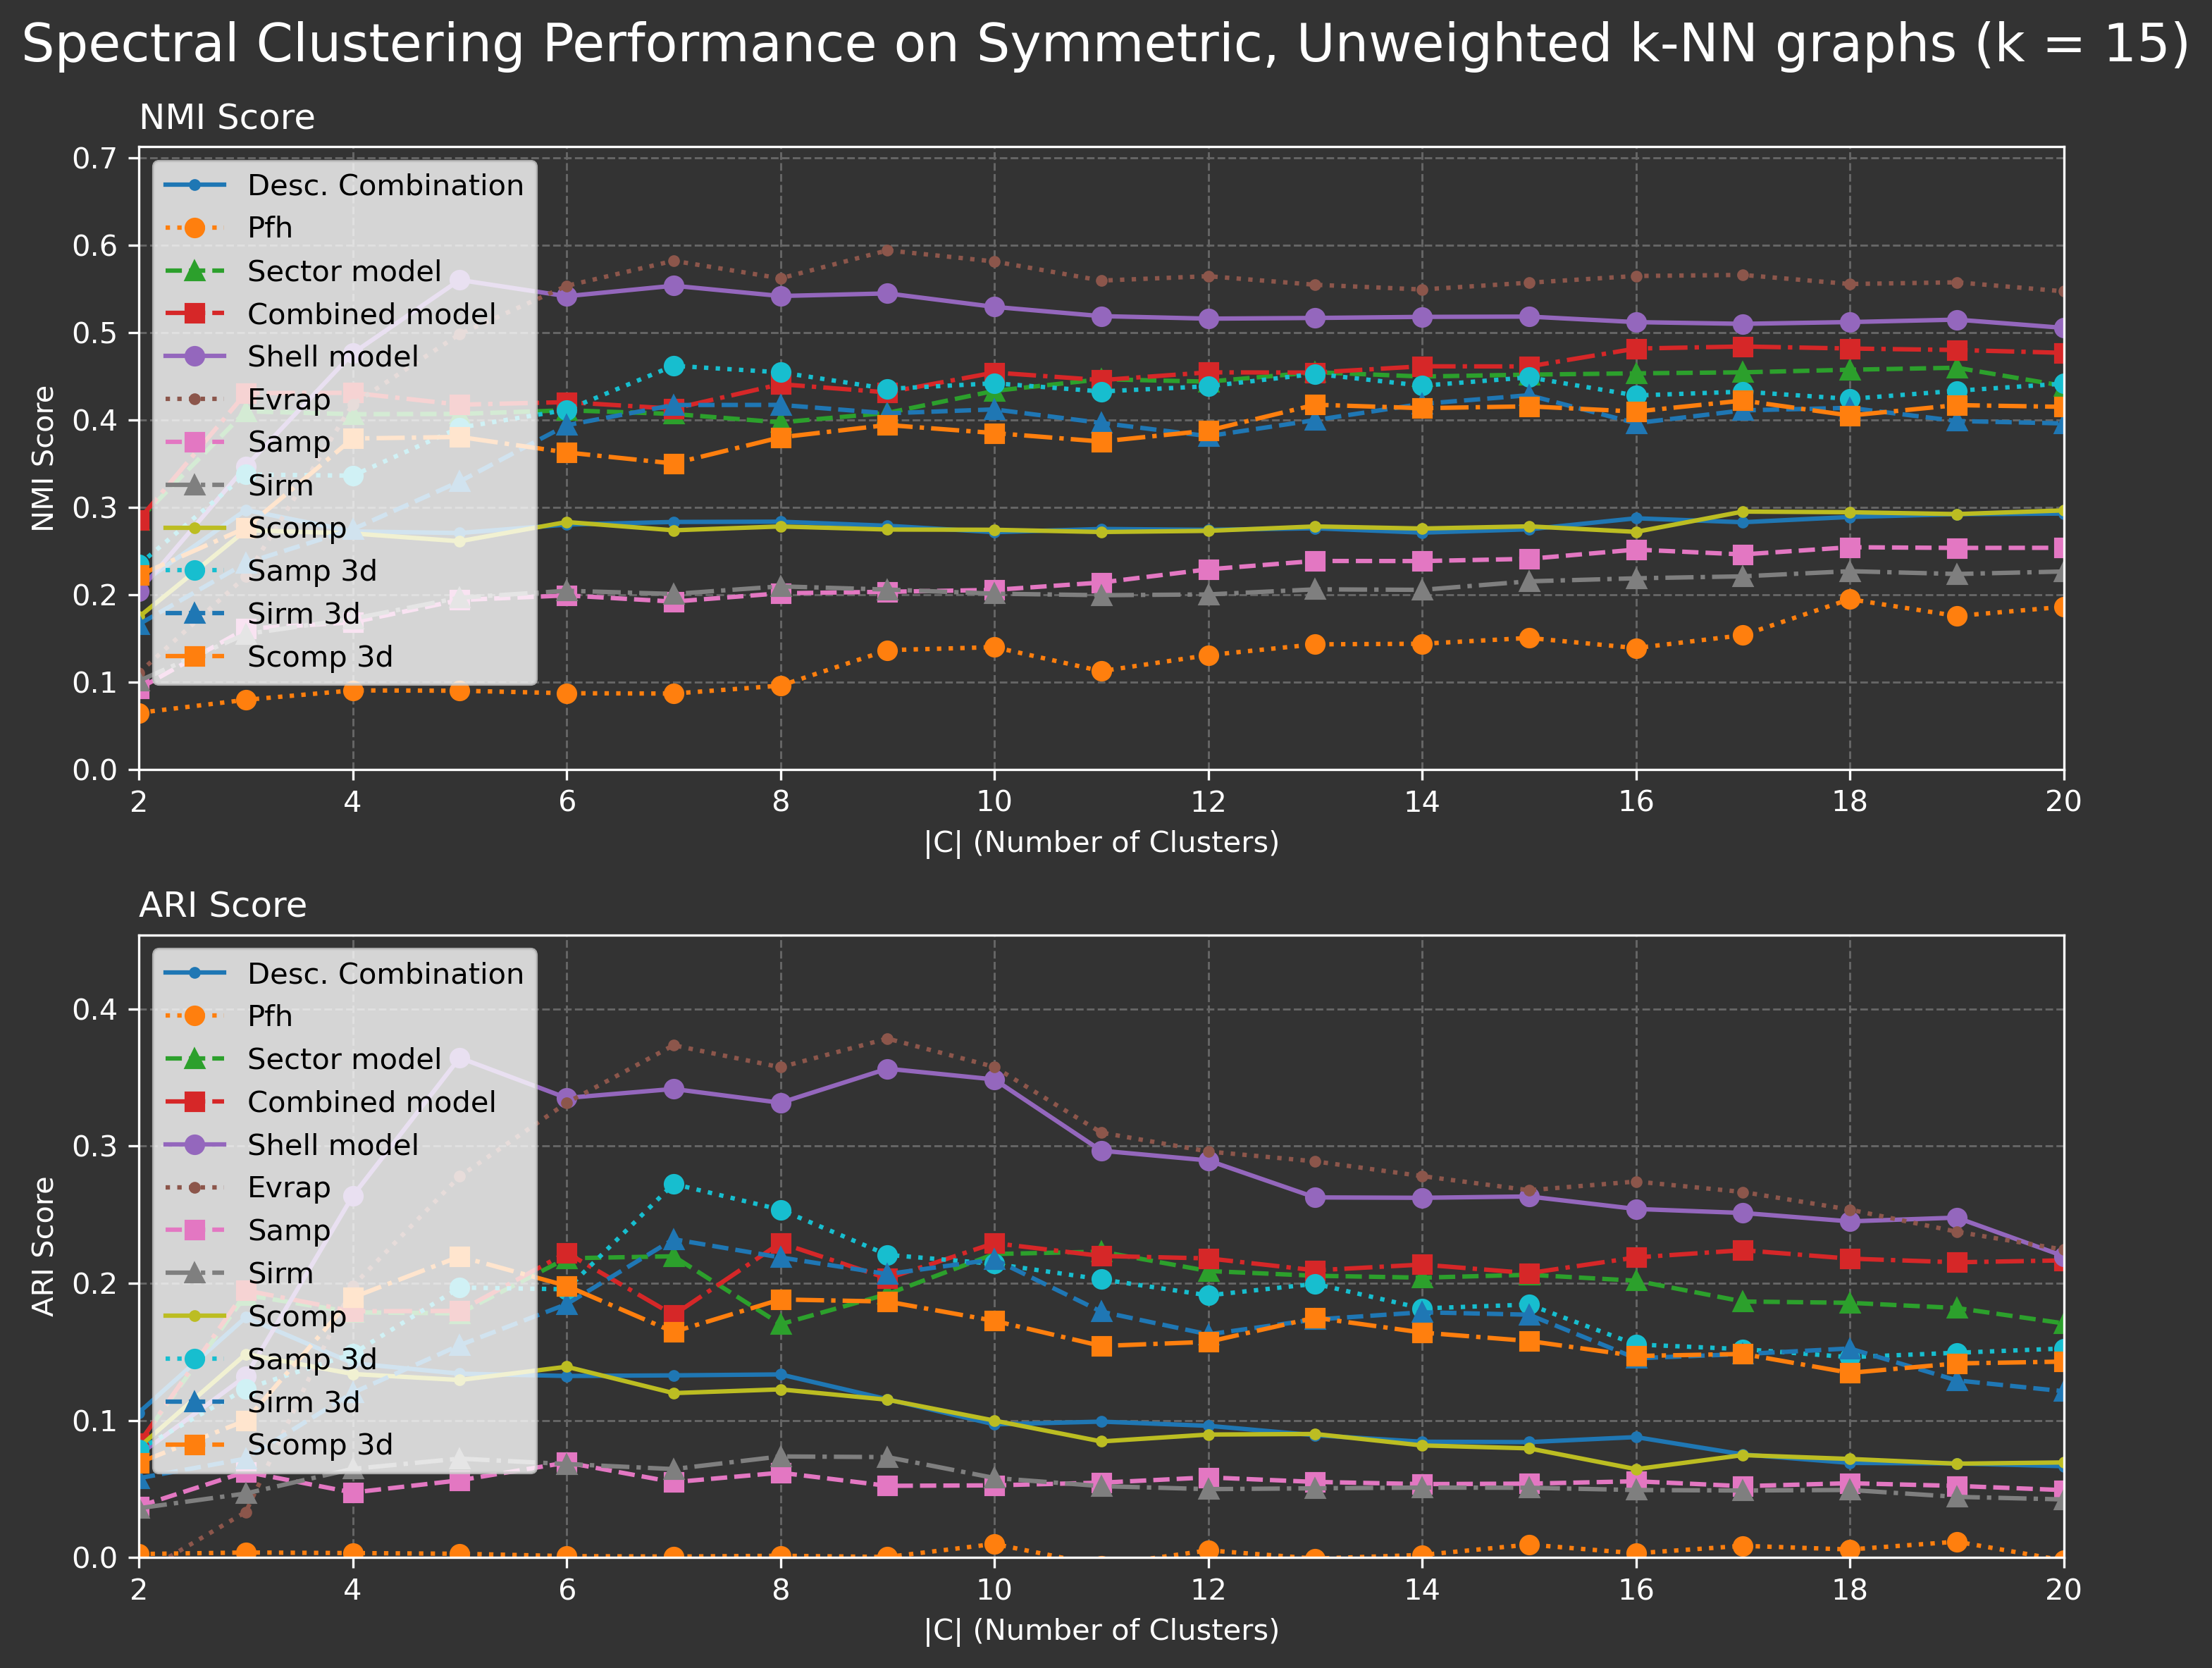

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=300)  # Example with a 2x2 grid of subplots

plot_evaluation(axes[0], descriptors, data['nmi'], data['cluster_size'],
                x_label='|C| (Number of Clusters)', y_label='NMI Score',
                title='NMI Score')

plot_evaluation(axes[1], descriptors, data['ari'], data['cluster_size'],
                x_label='|C| (Number of Clusters)', y_label='ARI Score',
                title='ARI Score')

fig.suptitle(
    f"Spectral Clustering Performance on Symmetric, Unweighted k-NN graphs (k = 15)",
    color="white", fontsize=18, x=0.01, horizontalalignment="left"
)

fig.patch.set_facecolor('#333333')
fig.tight_layout()

plt.savefig(f"figures/proteins/nmi_ari/unweighted_symmetric_knn_nmi_ari_k15_mirrored.png")
plt.show()

# Testing with 11 clusters

In [45]:
df = compute_descriptors_from_file('proteins_mirrored')

In [46]:
df

,evrap,sirm,scomp,samp,sector_model,shell_model,combined_model,pfh,sirm_3d,scomp_3d,samp_3d,labels
0,"[0.6208264827728271, 0.23359280824661255, 0.14...",[0.7728291419515712],[39.18521370338386],"[0.5790386077296905, 0.786129609203401]","[748, 542, 304, 197, 117, 121, 146, 127, 128, ...","[11, 135, 304, 363, 455, 592, 657, 578, 478, 3...","[21.0, 95.0, 211.0, 192.0, 186.0, 43.0, 10.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.350783270715348, 2.3206168713083204, 2.1378...","[38.75773936808638, 38.223805604184896, 34.530...","[0.6471016996949012, 0.685499633980682, 0.7947...",0
1,"[0.4647943377494812, 0.31580933928489685, 0.21...",[0.7034646614408165],[32.71659363222559],"[0.40541996827399696, 0.5807803666583663]","[0, 0, 569, 1608, 85, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 12, 116, 242, 415, 513, 516, 346,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.0471283679990795, 2.181458432470726, 1.8819...","[32.071832366893716, 34.84462442963514, 27.506...","[0.5190440798150392, 0.5155570269315912, 0.568...",0
2,"[0.6281958818435669, 0.23101778328418732, 0.14...",[0.7552542475315764],[36.73248371151299],"[0.5143773482541398, 0.7114831622154628]","[800, 549, 288, 191, 108, 99, 145, 112, 130, 1...","[12, 187, 311, 382, 474, 634, 690, 602, 480, 2...","[18.0, 104.0, 195.0, 204.0, 226.0, 53.0, 12.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.3457513594914534, 2.3710457679484085, 2.169...","[36.54031456674399, 37.79934741263685, 33.4880...","[0.5918699107918889, 0.6334057546866012, 0.762...",0
3,"[0.618157684803009, 0.23655152320861816, 0.145...",[0.7019152902479514],[33.90934425737308],"[0.4026858968645321, 0.5750298389850097]","[2183, 60, 0, 0, 0, 0, 0, 0, 9, 109, 427, 1746]","[0, 13, 207, 425, 562, 719, 588, 650, 543, 465...","[2.0, 167.0, 520.0, 769.0, 524.0, 201.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.1977533790733306, 2.4229212812487106, 2.159...","[33.97709571569213, 37.039923852143836, 32.459...","[0.46269611694752283, 0.4623705347920557, 0.67...",0
4,"[0.49027374386787415, 0.3468685746192932, 0.16...",[0.7187655981828203],[41.785228212976186],"[0.3604602275194708, 0.5880304227189713]","[2673, 2335, 1442, 477, 1, 0, 1, 0, 6, 648, 18...","[42, 284, 626, 1150, 1557, 1938, 2102, 1978, 1...","[51.0, 411.0, 752.0, 804.0, 440.0, 215.0, 76.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.338867079087044, 2.2656408832846613, 2.1650...","[39.32780511782578, 39.843496607350424, 36.731...","[0.41821132328307076, 0.4817979076582021, 0.82...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
333,"[0.6748560070991516, 0.18580570816993713, 0.13...",[0.694160743251241],[38.947970662039126],"[0.28480689698552686, 0.49710439661148204]","[376, 699, 741, 230, 164, 261, 771, 822, 638, ...","[16, 136, 324, 592, 675, 920, 857, 736, 547, 4...","[3.0, 28.0, 86.0, 181.0, 75.0, 3.0, 12.0, 55.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.071334490192896, 2.0079136153998394, 2.0866...","[33.96226974243721, 31.868351134068757, 33.766...","[0.27798067001250076, 0.35107349806665933, 0.4...",-7
334,"[0.6756508350372314, 0.1861530989408493, 0.138...",[0.6639894284803597],[35.6854983914382],"[0.21683398379558125, 0.4203189844284666]","[237, 158, 218, 712, 657, 362, 129, 209, 441, ...","[15, 134, 322, 569, 654, 899, 817, 696, 509, 4...","[9.0, 35.0, 19.0, 36.0, 64.0, 74.0, 7.0, 45.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.9987386088368644, 2.0257392531939713, 2.022...","[32.13077141349319, 31.70638447150412, 31.5700...","[0.23383181993141033, 0.2589491391723545, 0.45...",-7
335,"[0.6709000468254089, 0.1860426366329193, 0.143...",[0.689407968901545],[36.78122643788747],"[0.25704698545247895, 0.46562259116056626]","[2153, 3498, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]","[0, 0, 6, 260, 719, 1043, 1095, 714, 591, 627,...","[0.0, 32.0, 653.0, 1059.0, 293.0, 116.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [75]:
def create_scatterplot_2d(ax, plot_data_x, plot_data_y, plot_labels, label_x='', label_y='', ax_title=''):
    # Map classes to colors
    unique_classes = plot_labels.unique()
    colors = plt.cm.tab10(range(len(unique_classes)))
    class_color_map = dict(zip(unique_classes, colors))

    # Plot points by class
    for class_label in unique_classes:
        class_data_x = plot_data_x[plot_labels == class_label]
        class_data_y = plot_data_y[plot_labels == class_label]
        ax.scatter(
            class_data_x, class_data_y,
            color=class_color_map[class_label], label=class_label, s=50
        )

    if ax_title != '':
        ax.set_title(ax_title, color='white', loc="left")
        
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)

    ax.set_facecolor('#333333')

    ax.tick_params(colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')

    ax.grid(True)
    ax.grid(color='#666666', linestyle='--', linewidth=0.7)

In [76]:
def run_enantiomer_test(descriptor_data, clusters=None, keep_other=True):
    if clusters is None:
        clusters = [-3, -7, 3, 7]
    descriptors_list = ['evrap', 'sirm_3d', 'samp_3d', 'scomp_3d']
    
    axis_labels = {
        0: 'x',
        1: 'y',
        2: 'z',
        3: 'w',
        4: 'v',
        5: 'u'
    }
    
    for desc in descriptors_list:
        # Get relevant data for plotting
        mirrored_clusters_idx = descriptor_data['labels'].isin(clusters)
        mirrored_clusters = np.stack(descriptor_data[mirrored_clusters_idx][desc].to_numpy())
        num_dims = mirrored_clusters.shape[1]
        
        # Prepare plot
        plot_fig, plot_axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
        title = f"Cluster Partitioning of Enantiomers using {desc.upper().replace('_', '')}"
        plot_fig.suptitle(title, color="white", fontsize=18, x=0.01, horizontalalignment="left")
    
        # Compute clustering using best parameters
        label_file_name = (f'test_output/proteins_mirrored_{desc}_labelling'
                           f'{"_all" if keep_other else "".join(str(cluster) for cluster in clusters)}.csv')
        if os.path.isfile(label_file_name):
            preds = pd.read_csv(label_file_name)
        else:
            cluster_data = descriptor_data.copy()
            if not keep_other:
                cluster_data = cluster_data[mirrored_clusters_idx]
                
            graph = compute_knn(cluster_data, descriptor_list=desc, n_neighbors=15, variant='symmetric',
                                mode='connectivity')
            n_clusters = 11 if keep_other else len(clusters)
            spectral_clustering = SpectralClustering(
                n_clusters=n_clusters,
                affinity='precomputed',
                random_state=42,
                n_jobs=-1
            )
            preds = spectral_clustering.fit_predict(graph)
            true = cluster_data['labels'].to_numpy()
            preds = pd.DataFrame({'pred_labels': preds, 'true_labels': true})
            preds.to_csv(label_file_name)
        
        if keep_other:
            true = preds[mirrored_clusters_idx]['true_labels']
            preds = preds[mirrored_clusters_idx]['pred_labels']
        else:
            true = preds['true_labels']
            preds = preds['pred_labels']
            
        pca = PCA(n_components=2, random_state=42)
        plot_data = pca.fit_transform(mirrored_clusters)
                
        create_scatterplot_2d(plot_axes[0], plot_data[:, 0], plot_data[:, 1], preds, 'PC 1', 'PC 2', 'Predictions')
        create_scatterplot_2d(plot_axes[1], plot_data[:, 0], plot_data[:, 1], true, 'PC 1', 'PC 2', 'True Labels')
    
        plot_fig.patch.set_facecolor('#333333')
        plot_fig.tight_layout()
        plt.savefig(f"figures/proteins/enantiomers_labelling/scatterplot_matrix_{desc}_predicted_labelling.png")
        plt.show()

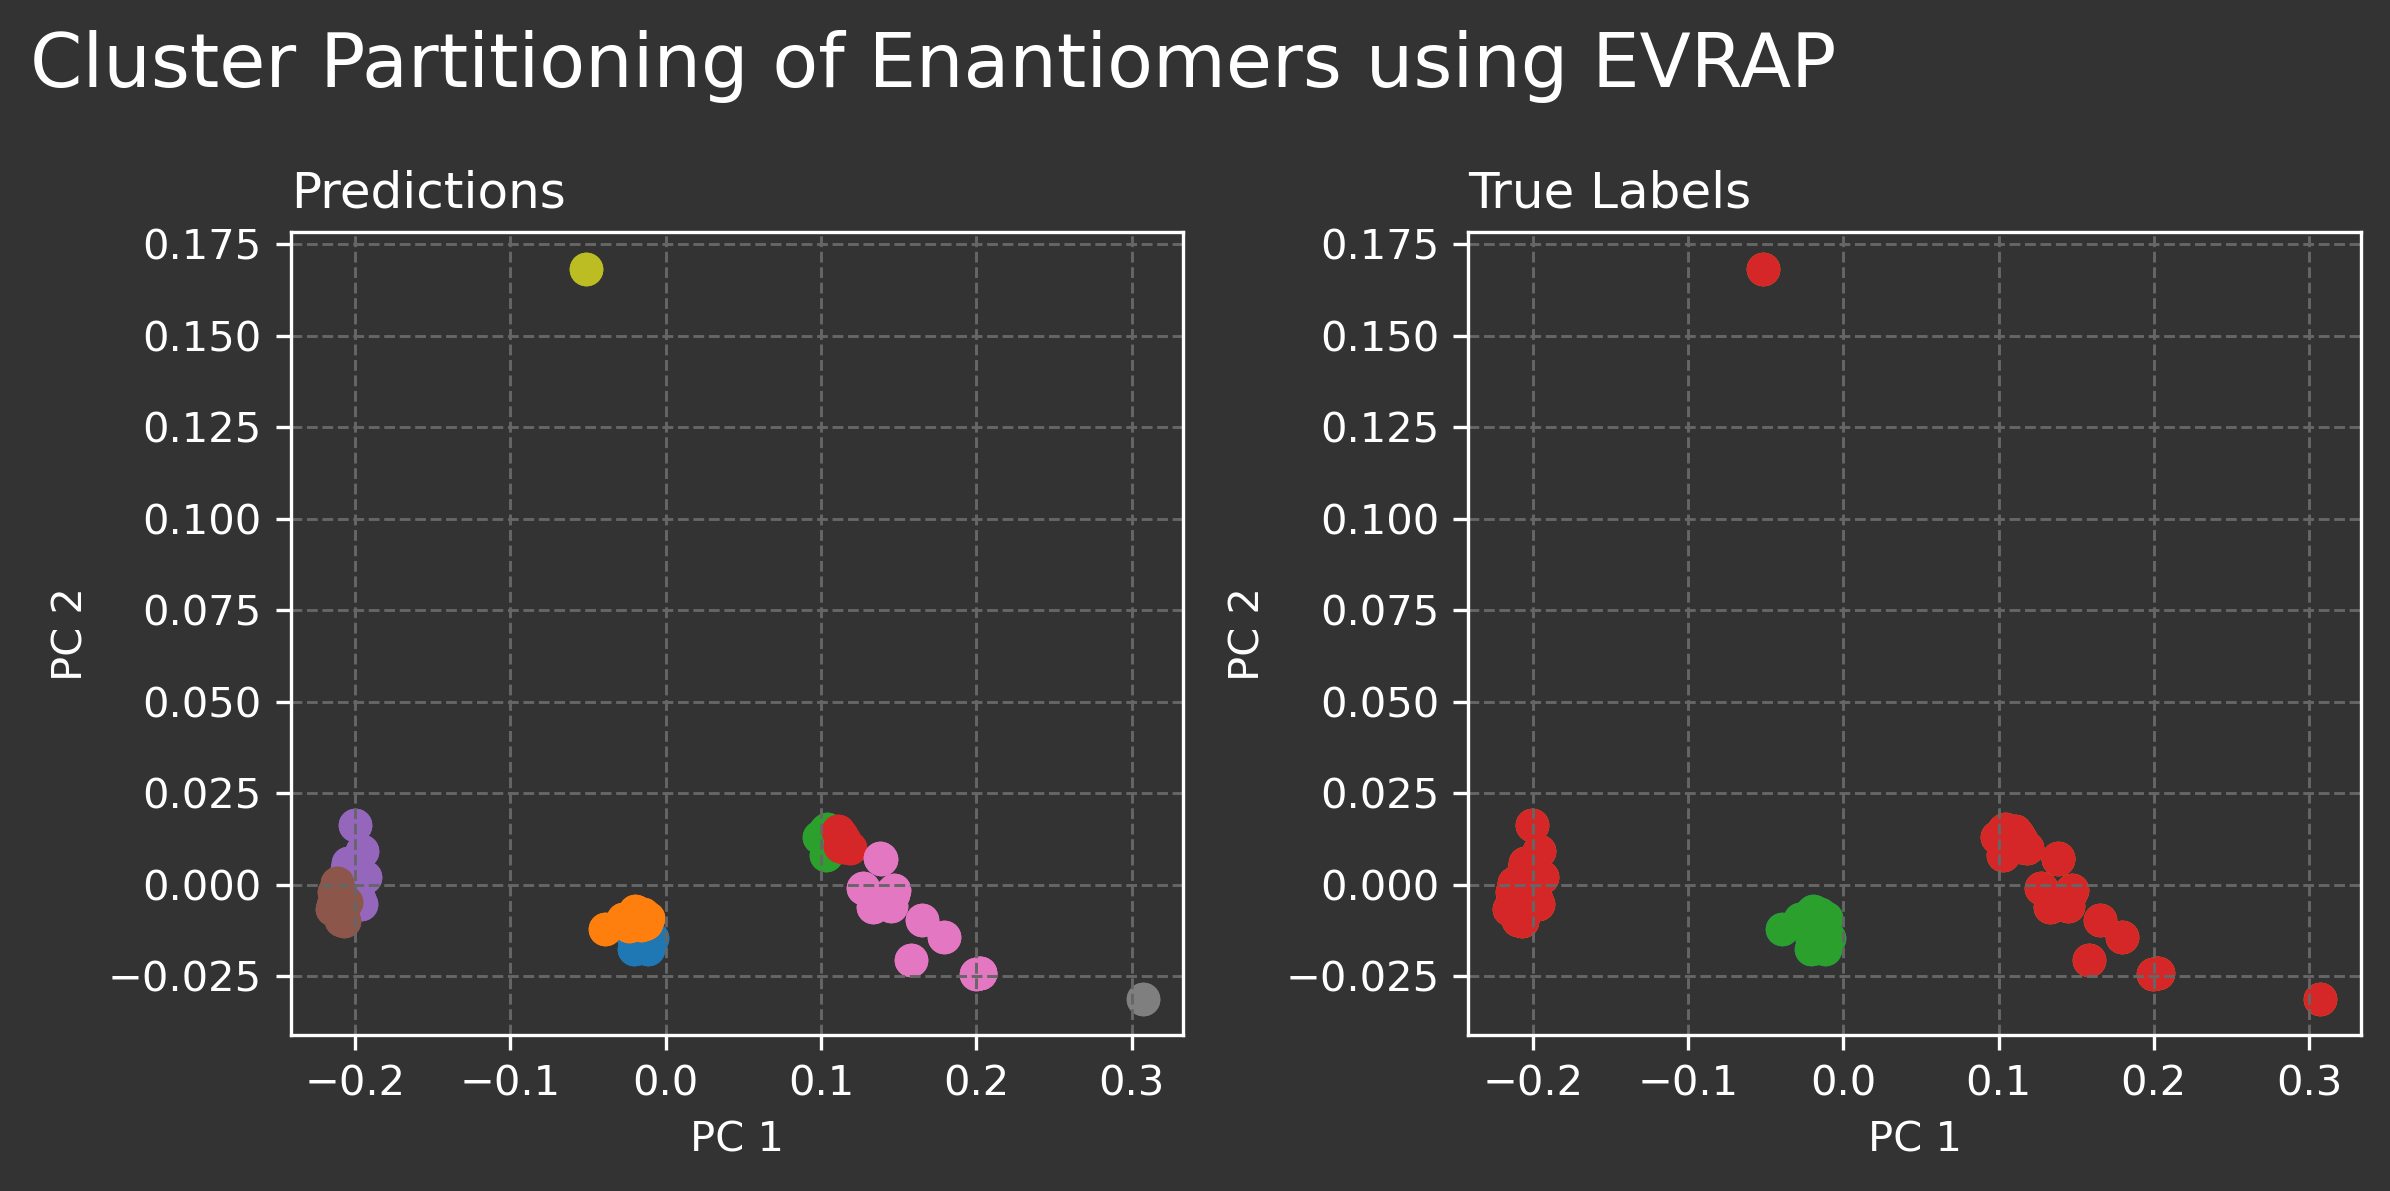

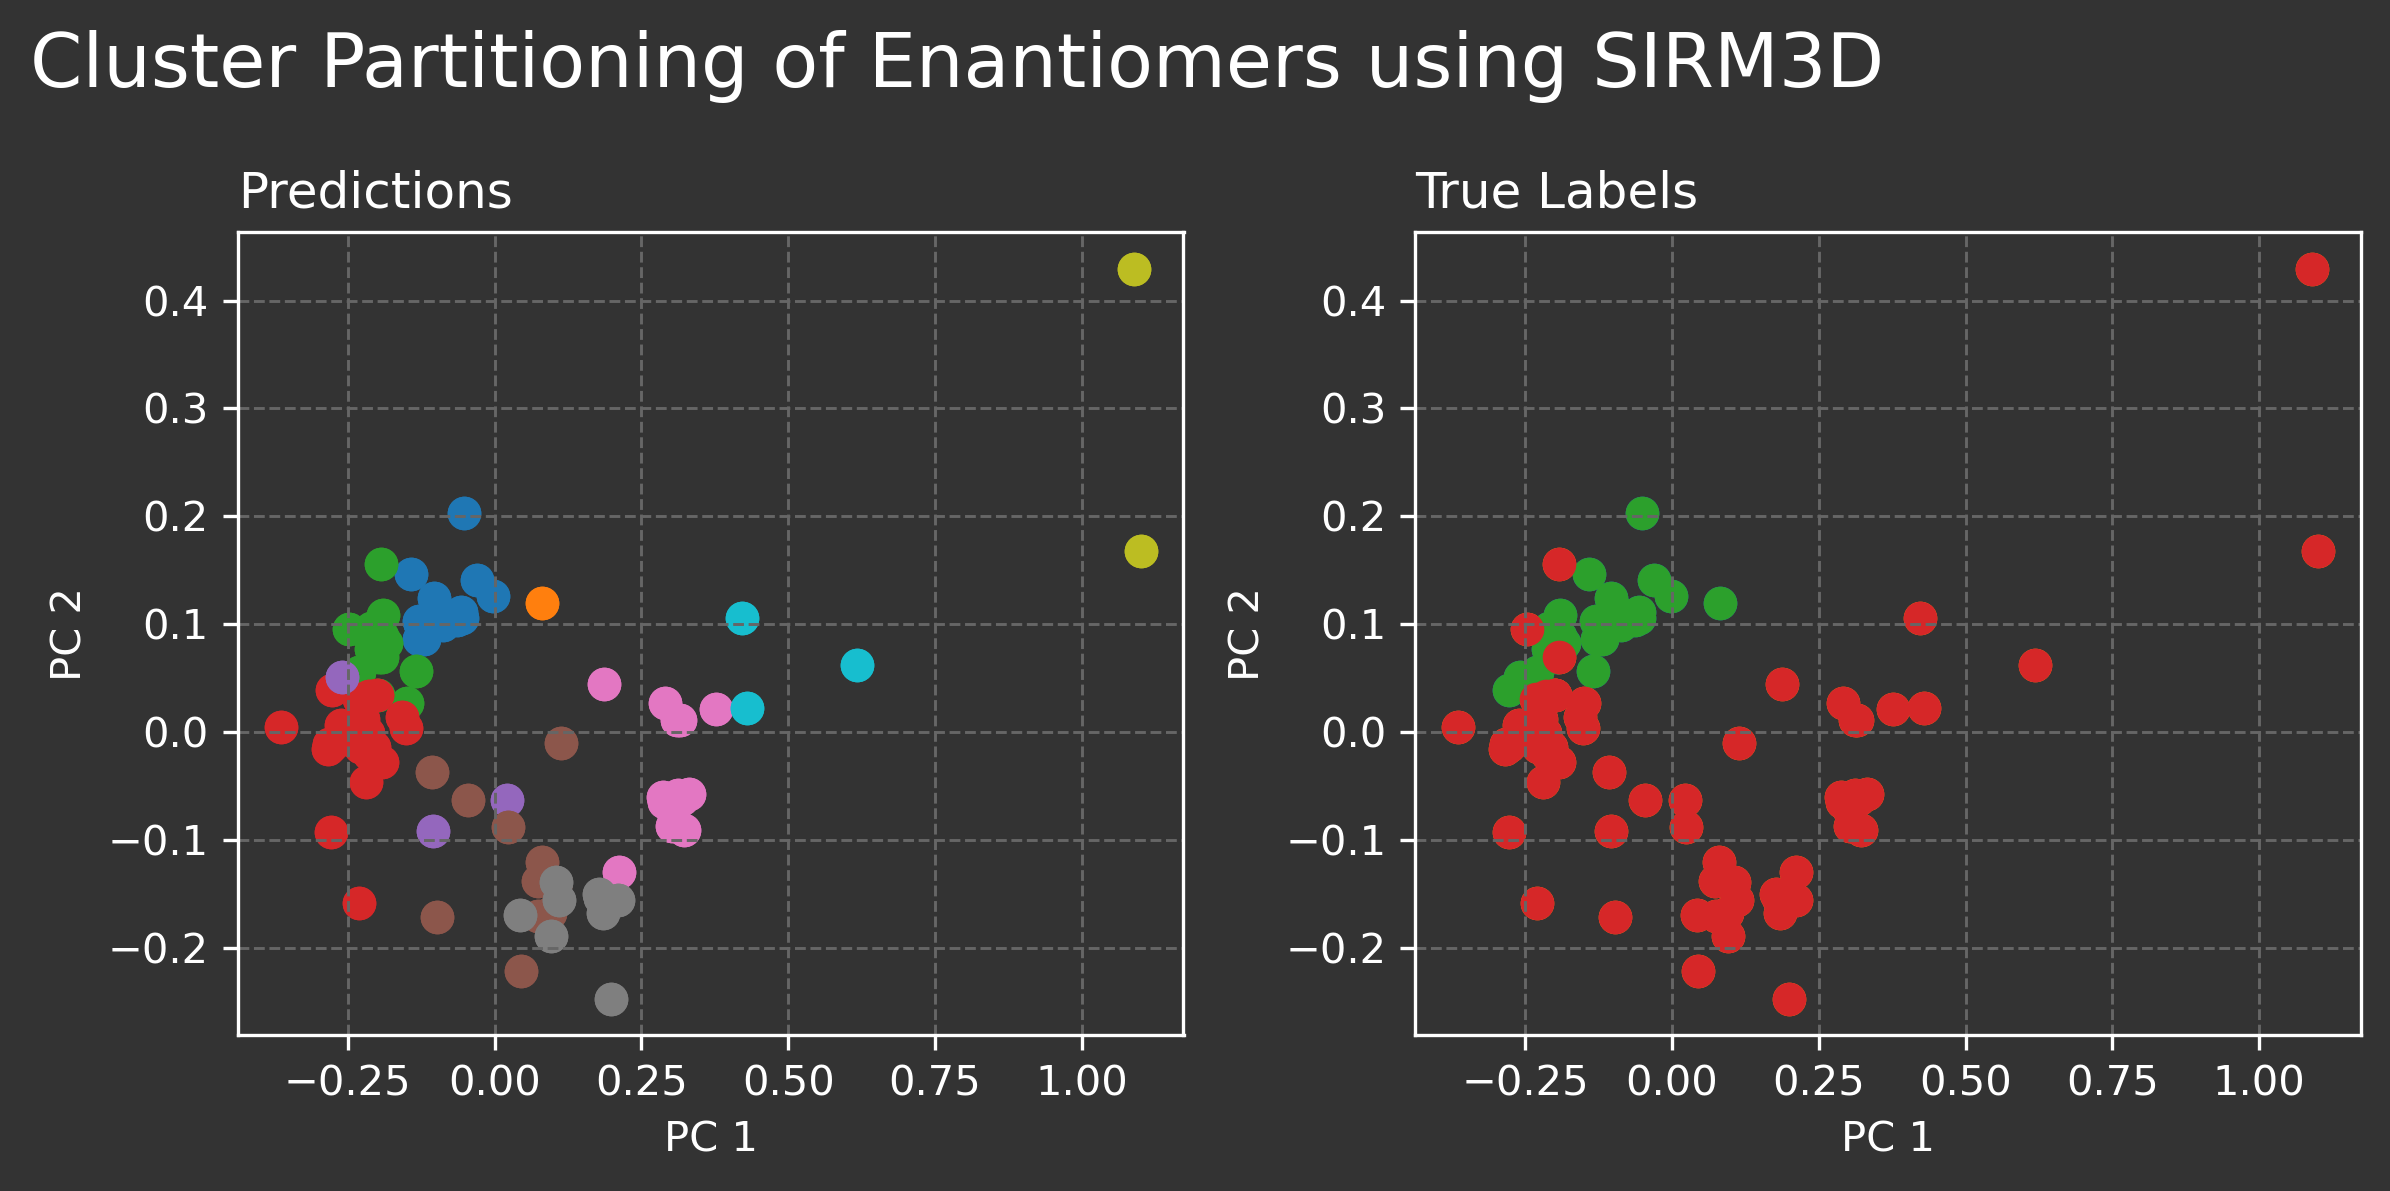

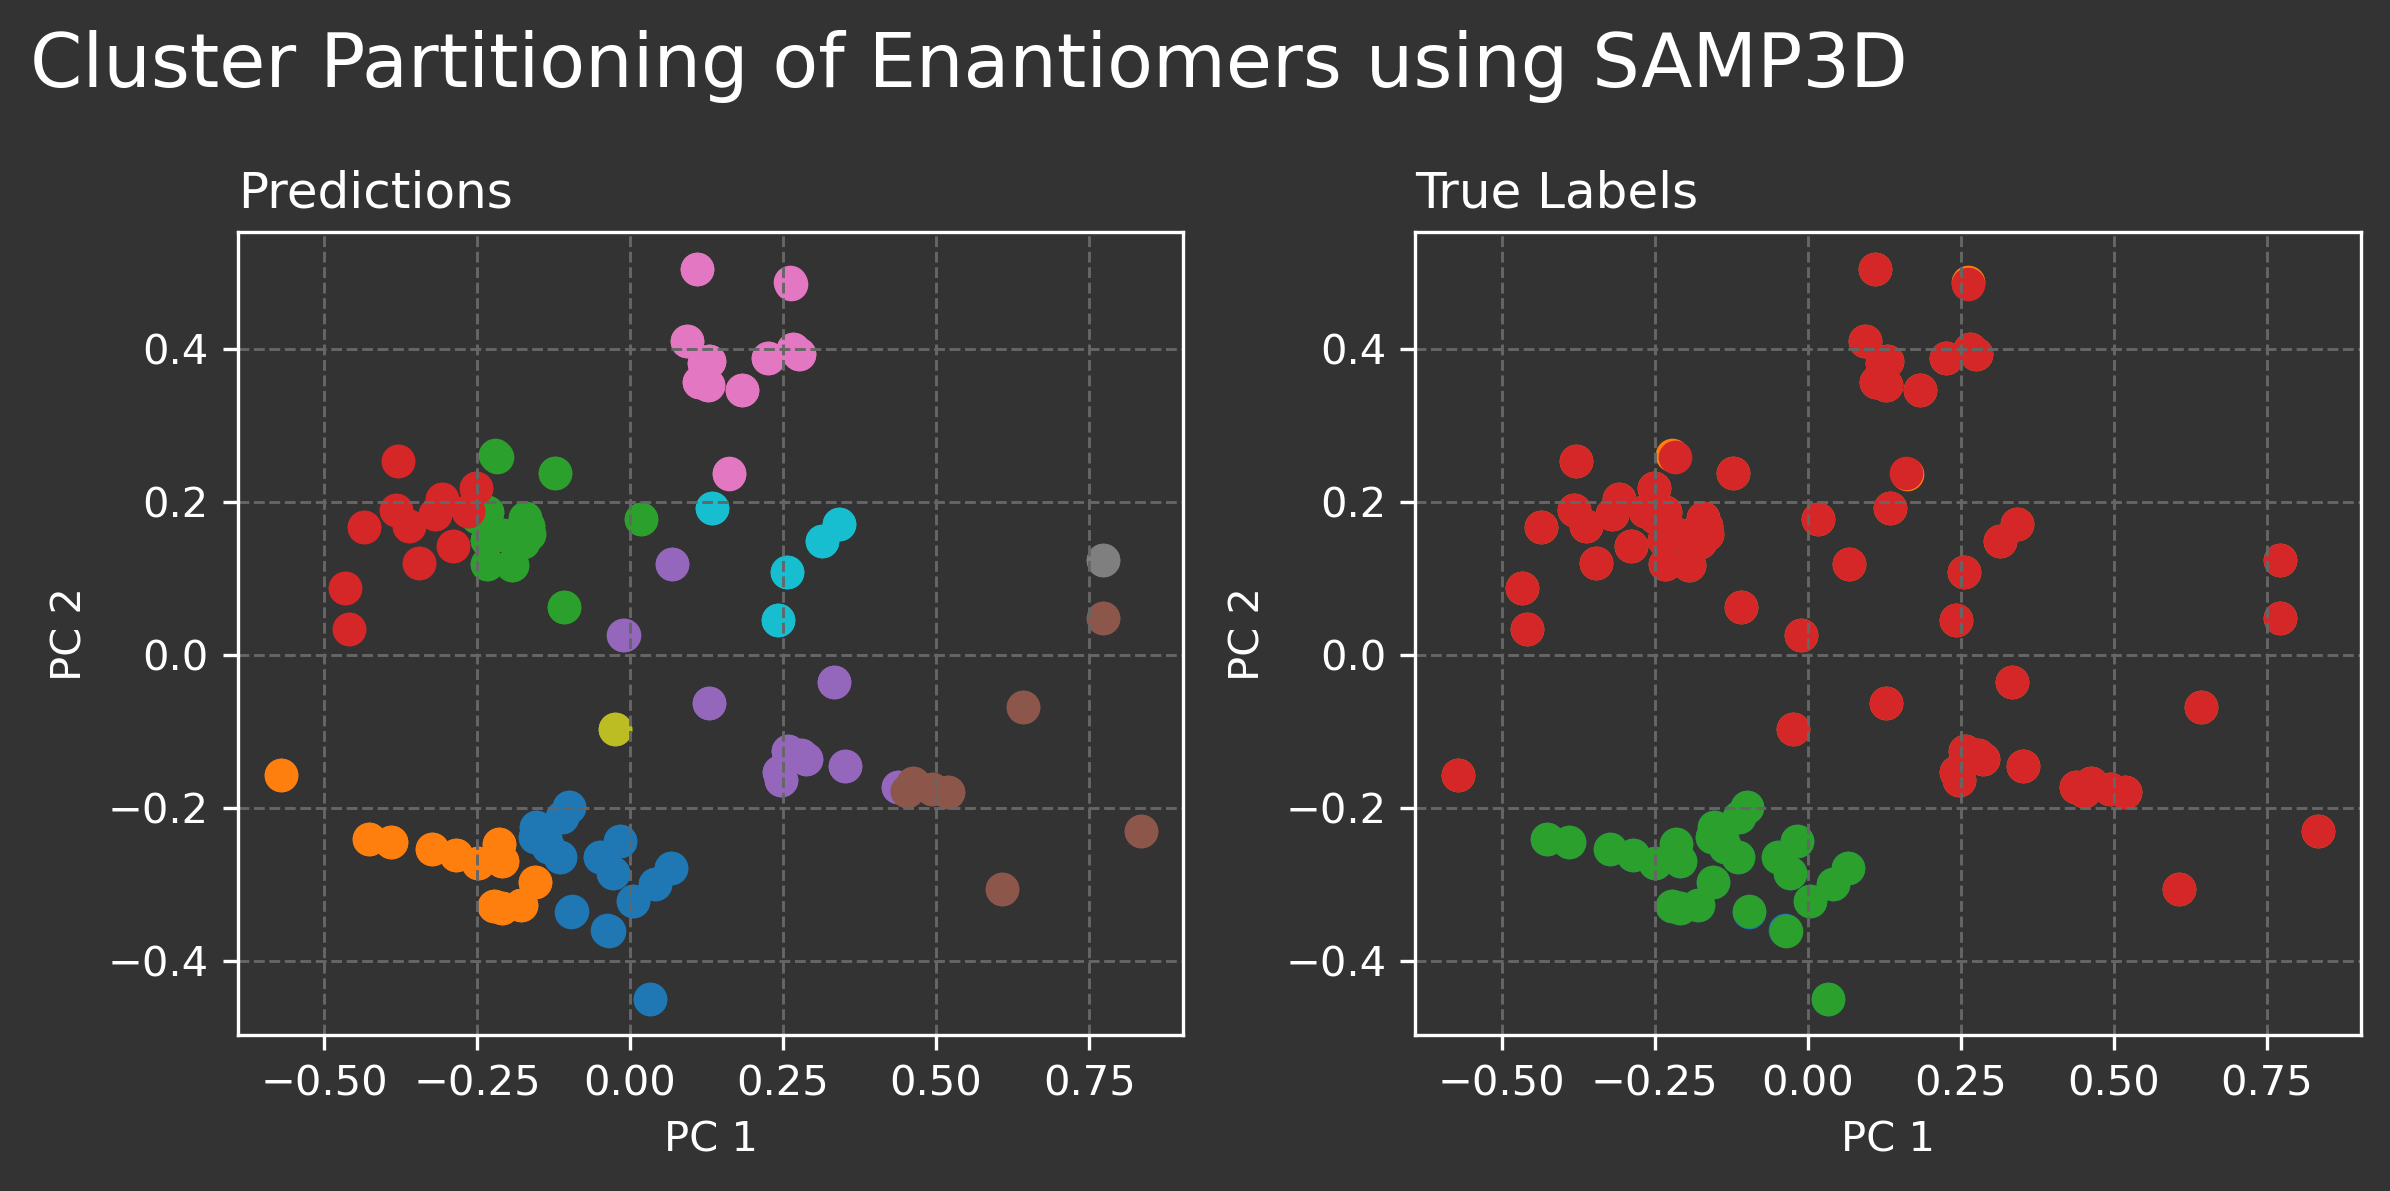

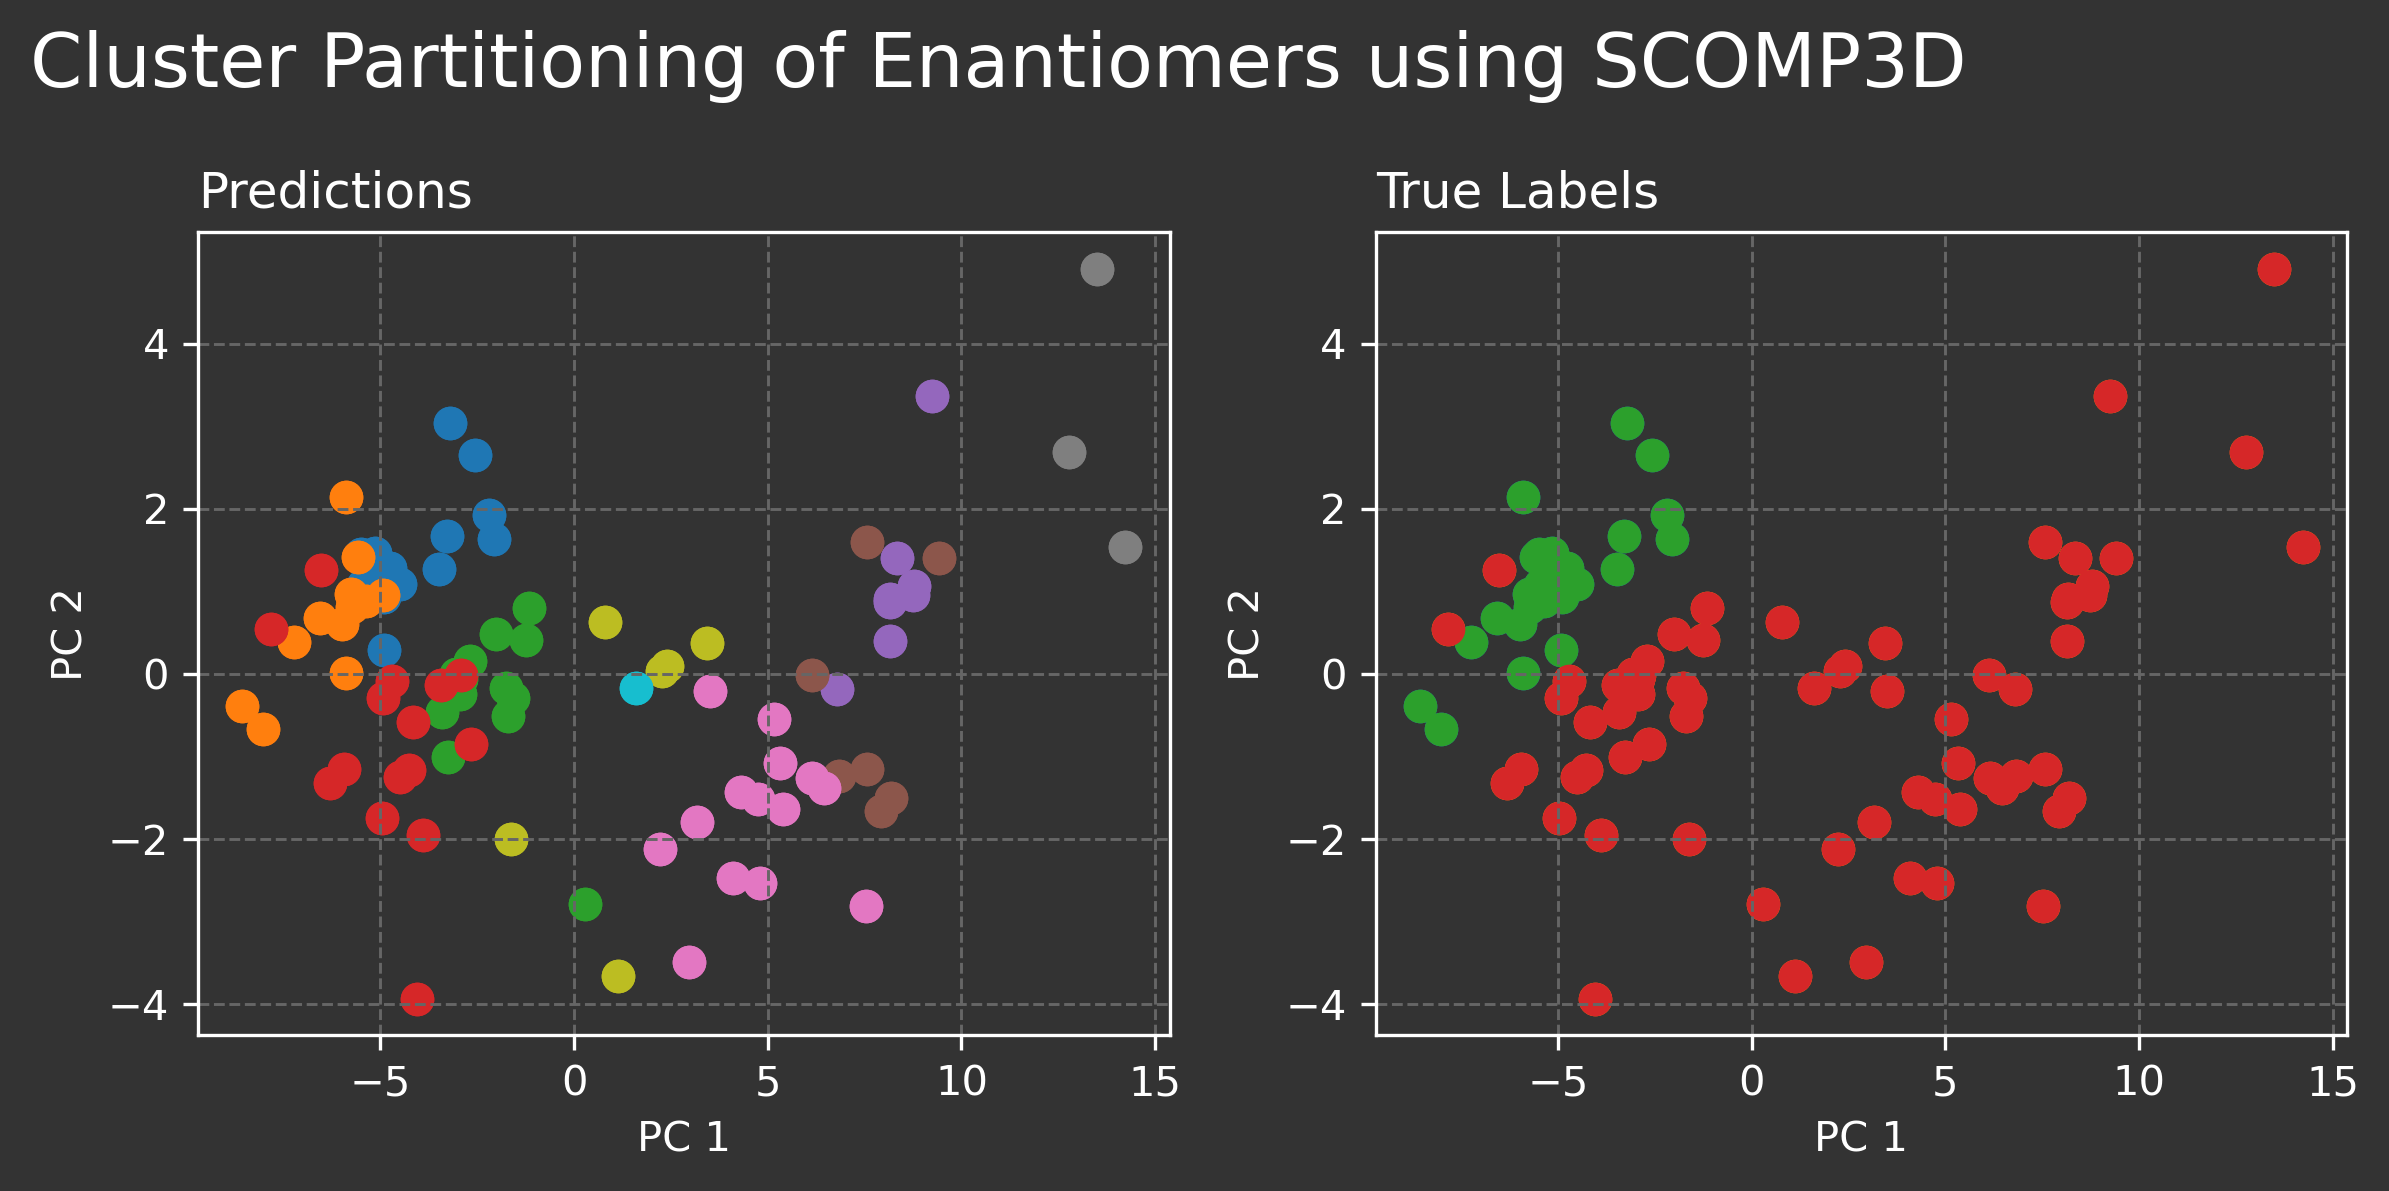

In [77]:
run_enantiomer_test(df)

As it seems, enantiomer can not be clustered using these descriptors, as the preprocessing aligns them back to the same representation. 

# Testing with just 2 clusters (one mirroring the other)

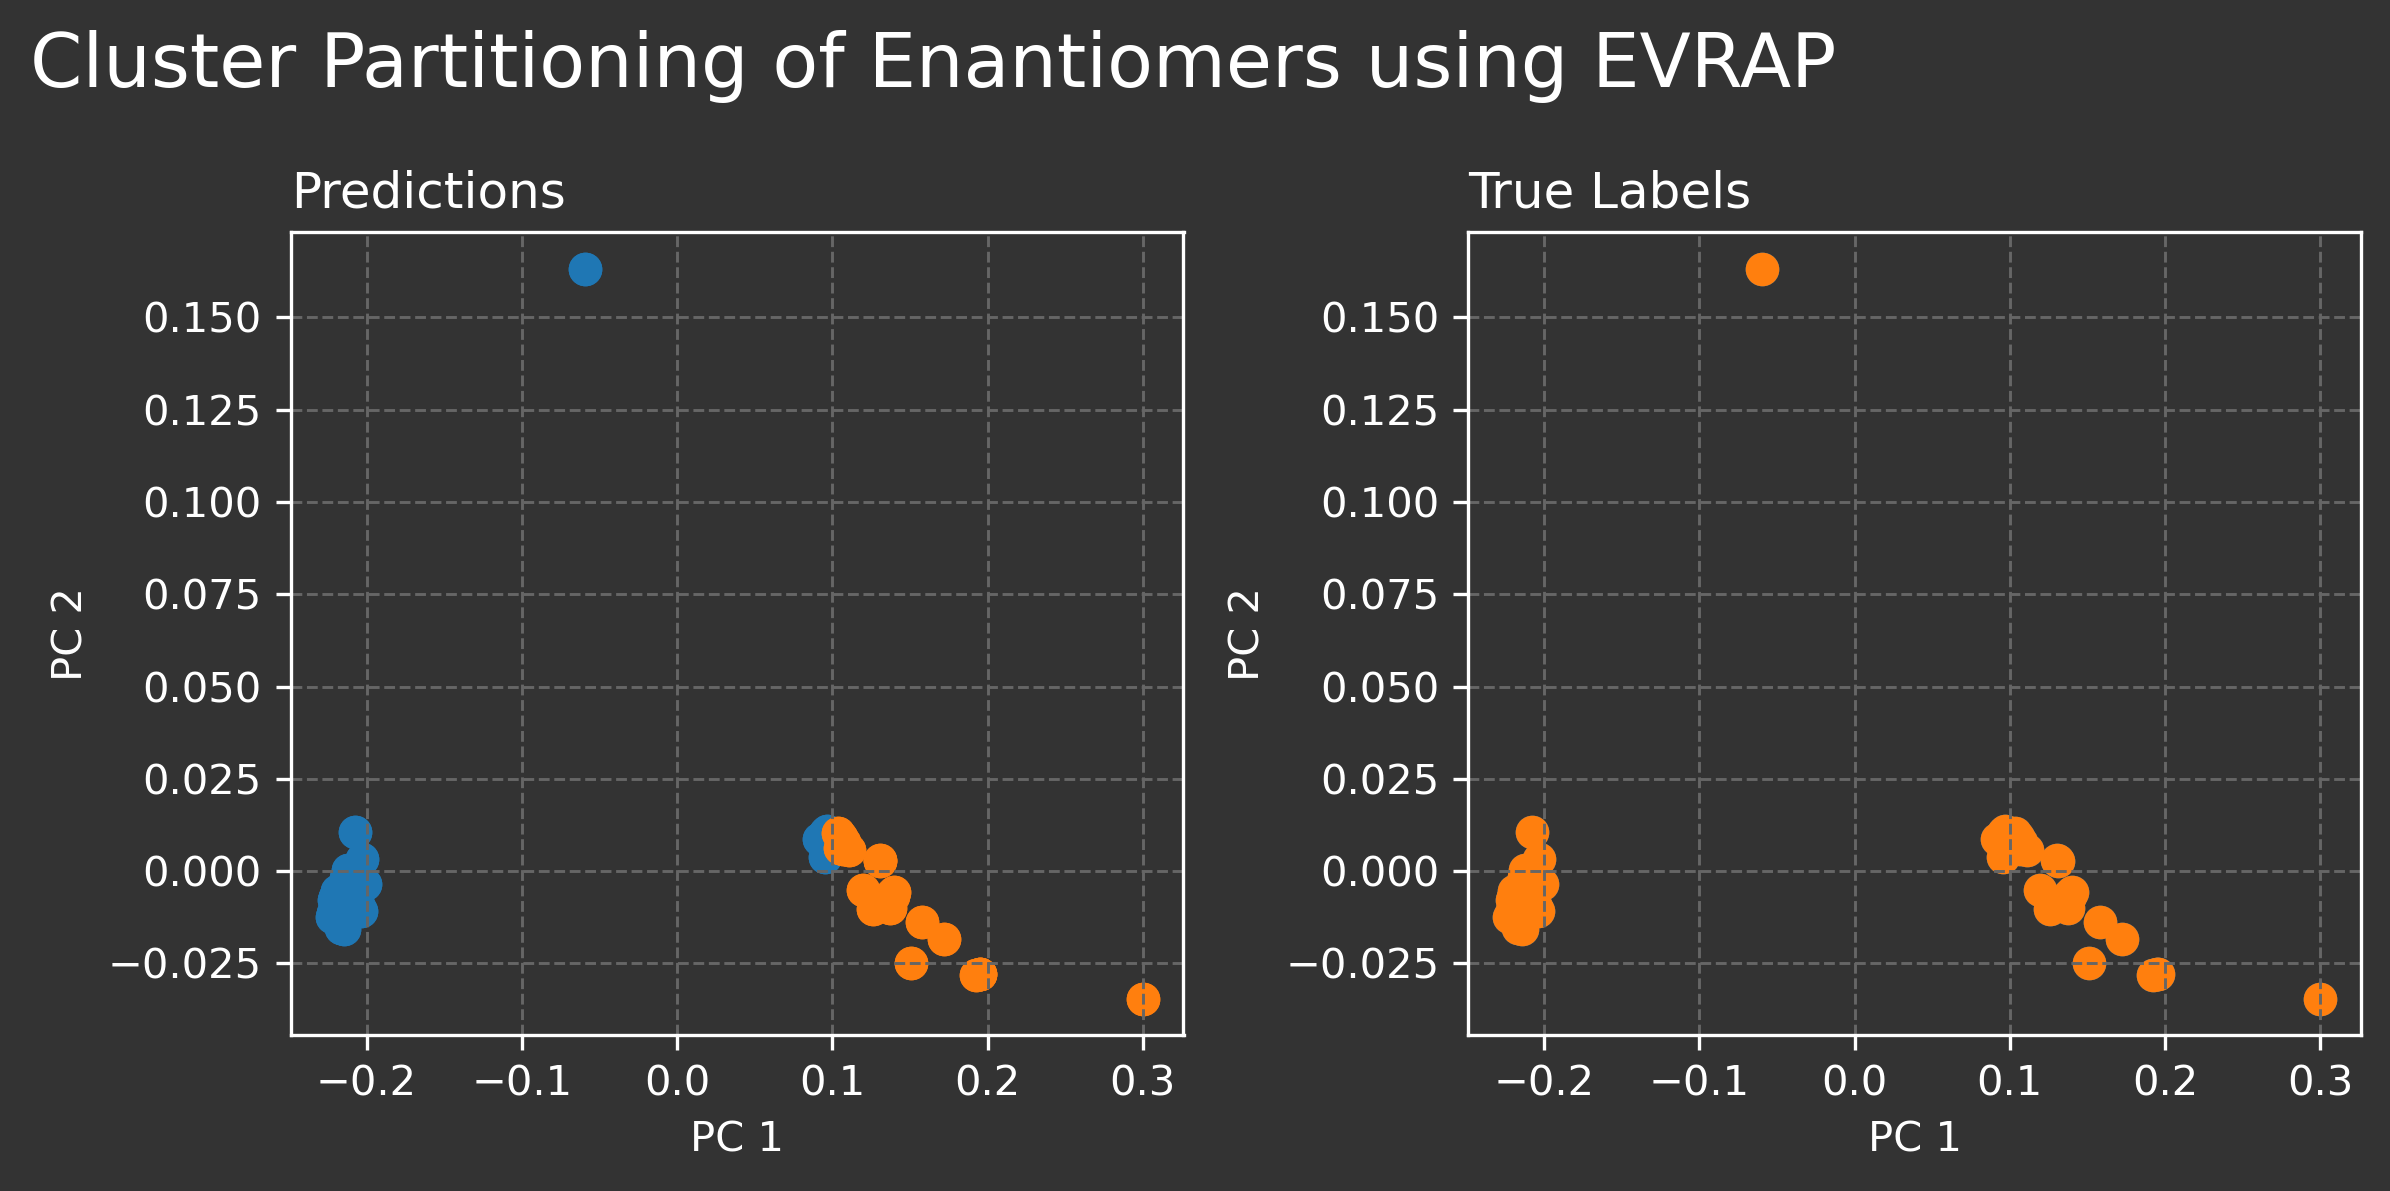

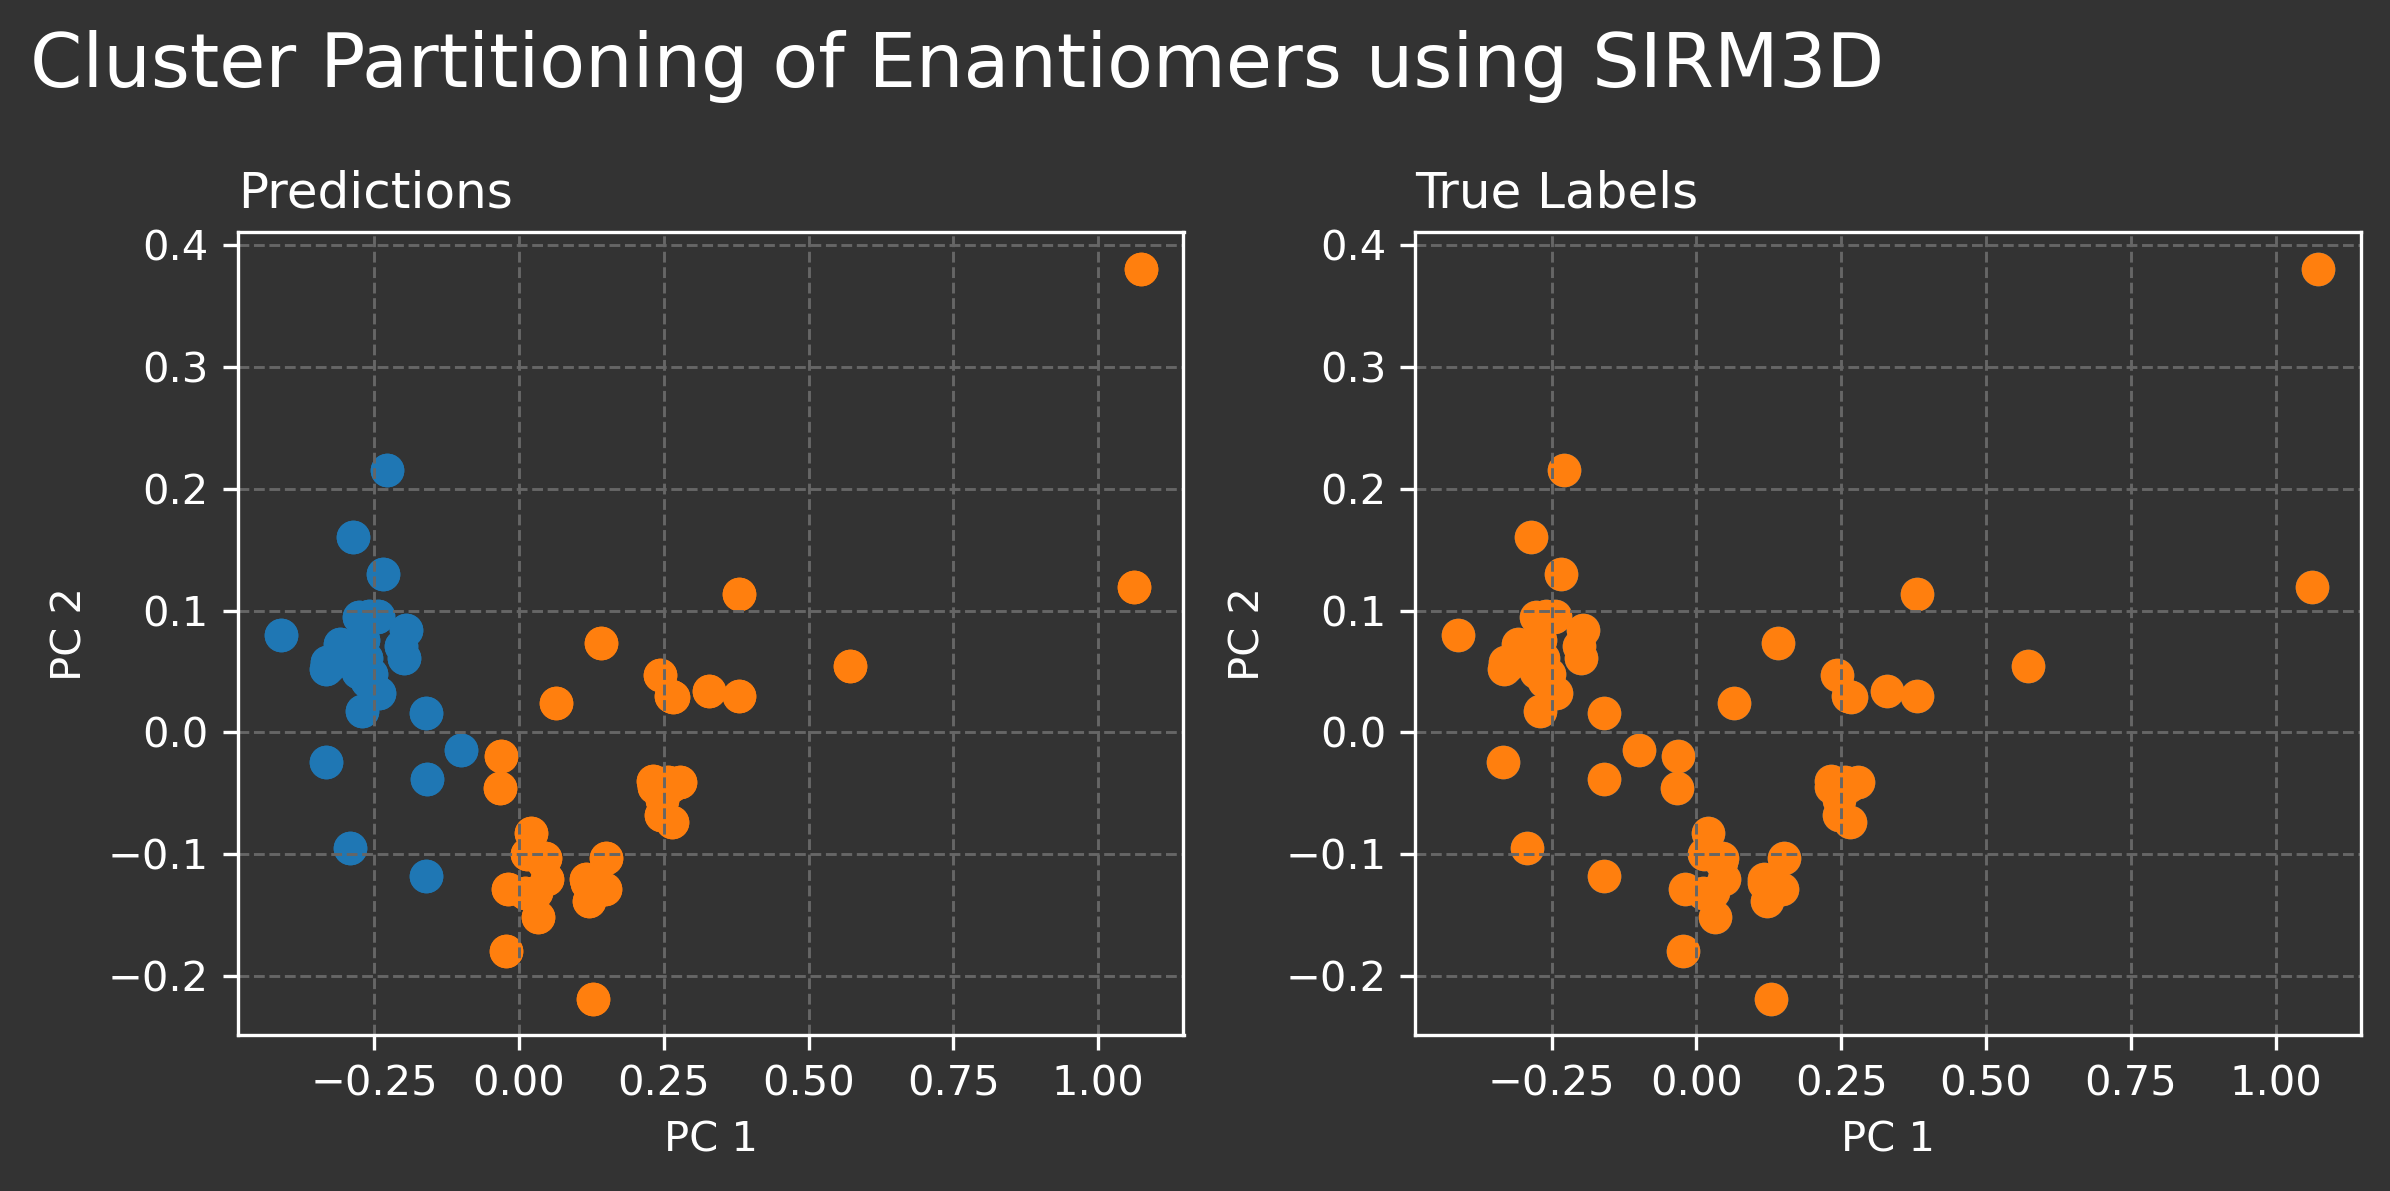

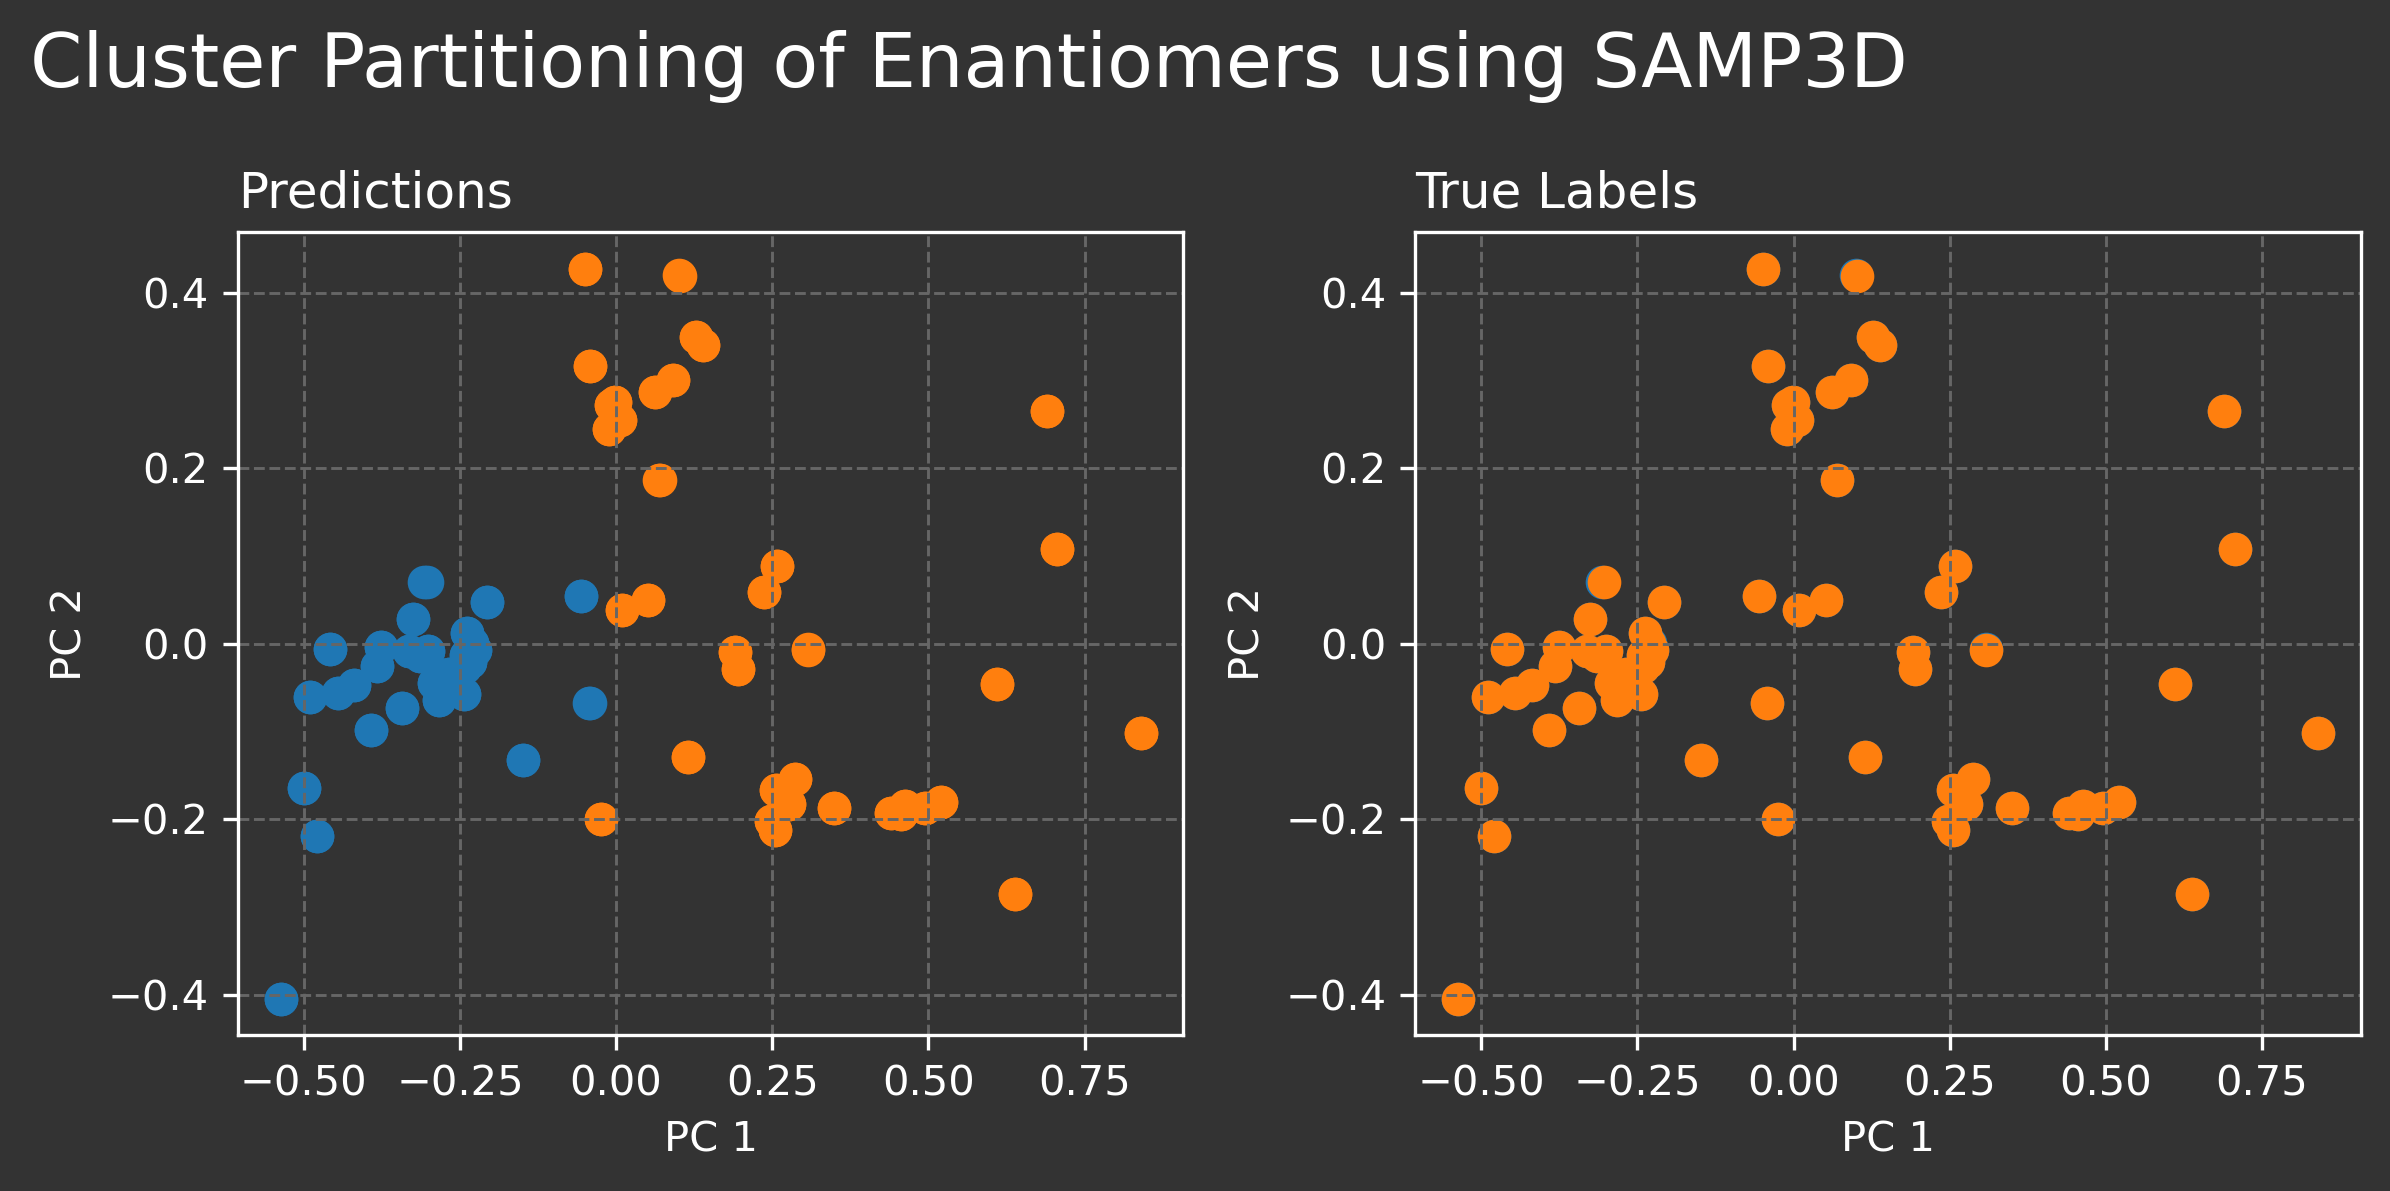

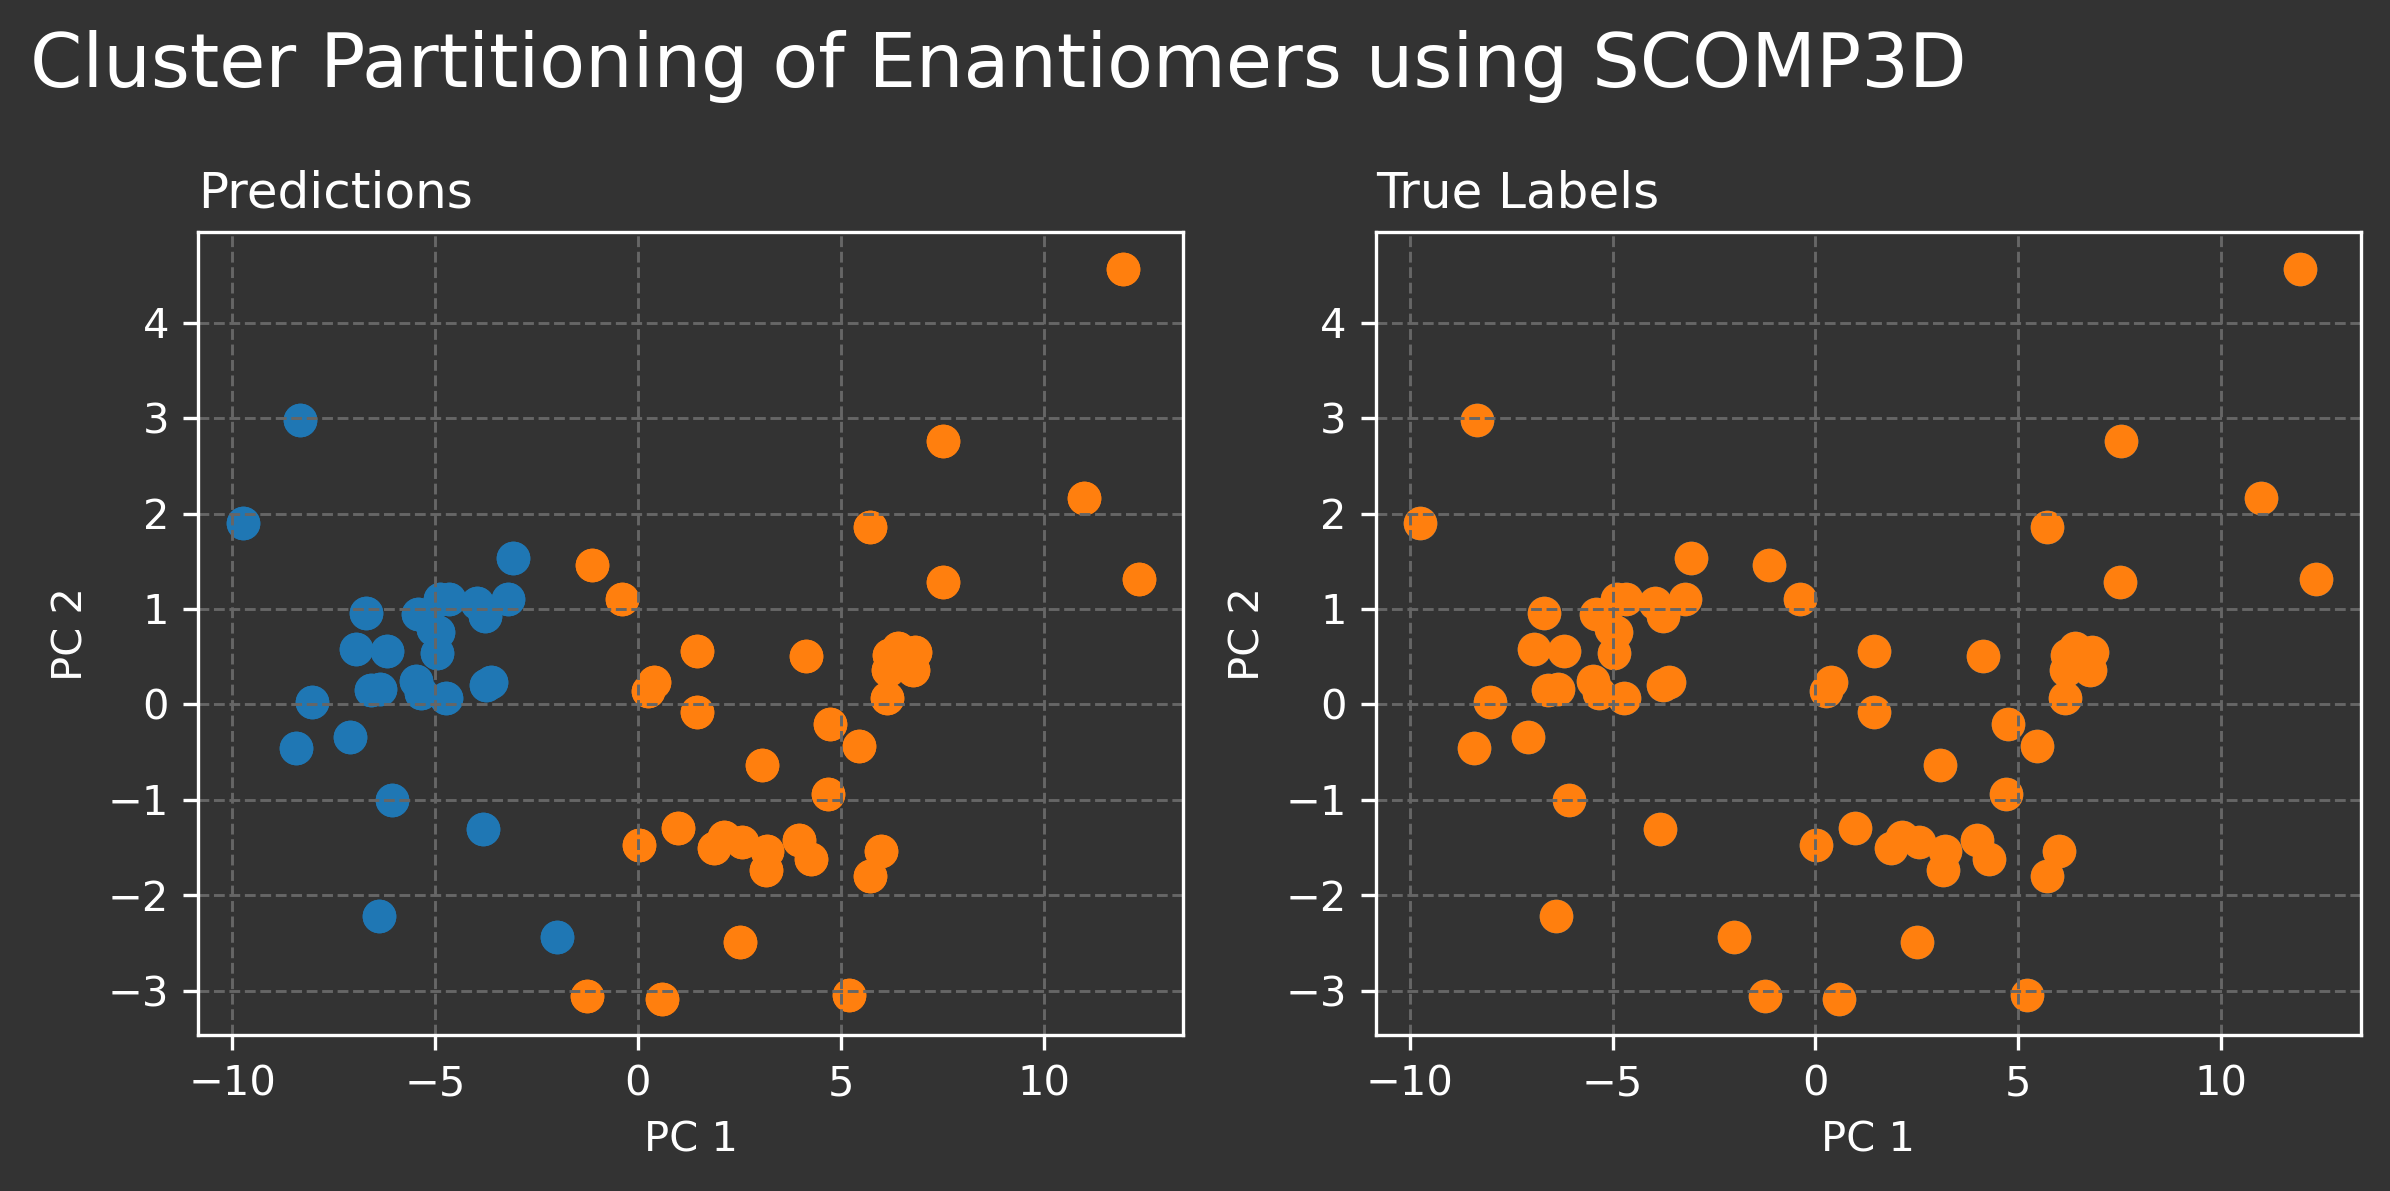

In [78]:
df = compute_descriptors_from_file('proteins_mirrored')
run_enantiomer_test(df, clusters=[7, -7], keep_other=False)